# Insurance cost prediction using linear regression

Make a submisson here: https://jovian.ai/learn/deep-learning-with-pytorch-zero-to-gans/assignment/assignment-2-train-your-first-model

In this assignment we're going to use information like a person's age, sex, BMI, no. of children and smoking habit to predict the price of yearly medical bills. This kind of model is useful for insurance companies to determine the yearly insurance premium for a person. The dataset for this problem is taken from [Kaggle](https://www.kaggle.com/mirichoi0218/insurance).


We will create a model with the following steps:
1. Download and explore the dataset
2. Prepare the dataset for training
3. Create a linear regression model
4. Train the model to fit the data
5. Make predictions using the trained model


This assignment builds upon the concepts from the first 2 lessons. It will help to review these Jupyter notebooks:
- PyTorch basics: https://jovian.ai/aakashns/01-pytorch-basics
- Linear Regression: https://jovian.ai/aakashns/02-linear-regression
- Logistic Regression: https://jovian.ai/aakashns/03-logistic-regression
- Linear regression (minimal): https://jovian.ai/aakashns/housing-linear-minimal
- Logistic regression (minimal): https://jovian.ai/aakashns/mnist-logistic-minimal

As you go through this notebook, you will find a **???** in certain places. Your job is to replace the **???** with appropriate code or values, to ensure that the notebook runs properly end-to-end . In some cases, you'll be required to choose some hyperparameters (learning rate, batch size etc.). Try to experiment with the hypeparameters to get the lowest loss.


In [5]:
# Uncomment and run the appropriate command for your operating system, if required

# Linux / Binder
# !pip install numpy matplotlib pandas torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# Windows
# !pip install numpy matplotlib pandas torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# MacOS
# !pip install numpy matplotlib pandas torch torchvision torchaudio

In [1]:
import torch
import jovian
import torchvision
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split

<IPython.core.display.Javascript object>

In [2]:
project_name='02-insurance-linear-regression' # will be used by jovian.commit
file_name="02-insurance-linear.ipynb"

## Step 1: Download and explore the data

Let us begin by downloading the data. We'll use the `download_url` function from PyTorch to get the data as a CSV (comma-separated values) file. 

In [3]:
DATASET_URL = "https://hub.jovian.ml/wp-content/uploads/2020/05/insurance.csv"
DATA_FILENAME = "insurance.csv"
download_url(DATASET_URL, '.')

Using downloaded and verified file: ./insurance.csv


To load the dataset into memory, we'll use the `read_csv` function from the `pandas` library. The data will be loaded as a Pandas dataframe. See this short tutorial to learn more: https://data36.com/pandas-tutorial-1-basics-reading-data-files-dataframes-data-selection/

In [4]:
dataframe_raw = pd.read_csv(DATA_FILENAME)
dataframe_raw.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


We're going to do a slight customization of the data, so that you every participant receives a slightly different version of the dataset. Fill in your name below as a string (enter at least 5 characters)

In [5]:
your_name = "Faaizz" # at least 5 characters

The `customize_dataset` function will customize the dataset slightly using your name as a source of random numbers.

In [6]:
def customize_dataset(dataframe_raw, rand_str):
    dataframe = dataframe_raw.copy(deep=True)
    # drop some rows
    dataframe = dataframe.sample(int(0.95*len(dataframe)), random_state=int(ord(rand_str[0])))
    # scale input
    dataframe.bmi = dataframe.bmi * ord(rand_str[1])/100.
    # scale target
    dataframe.charges = dataframe.charges * ord(rand_str[2])/100.
    # drop column
    if ord(rand_str[3]) % 2 == 1:
        dataframe = dataframe.drop(['region'], axis=1)
    return dataframe

In [7]:
dataframe = customize_dataset(dataframe_raw, your_name)
dataframe.head()

,age,sex,bmi,children,smoker,charges
425,45,male,23.58070,5,no,9495.199923
607,59,female,22.94535,0,yes,24908.415097
428,21,female,16.31055,1,no,3072.432174
1142,52,female,24.11420,0,no,26304.453967
1121,46,male,37.02490,2,no,8096.749371


Let us answer some basic questions about the dataset. 


**Q: How many rows does the dataset have?**

In [8]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1271 entries, 425 to 1217
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1271 non-null   int64  
 1   sex       1271 non-null   object 
 2   bmi       1271 non-null   float64
 3   children  1271 non-null   int64  
 4   smoker    1271 non-null   object 
 5   charges   1271 non-null   float64
dtypes: float64(2), int64(2), object(2)
memory usage: 69.5+ KB


In [9]:
dataframe.describe()

,age,bmi,children,charges
count,1271.000000,1271.000000,1271.000000,1271.000000
mean,39.253344,29.779828,1.104642,12827.439276
std,14.117684,5.909430,1.212495,11688.125001
min,18.000000,15.481200,0.000000,1088.217683
25%,27.000000,25.525550,0.000000,4609.782798
50%,39.000000,29.488000,1.000000,9080.486996
75%,51.000000,33.659000,2.000000,15959.702237
max,64.000000,51.536100,5.000000,61857.315170


In [10]:
num_rows = 1271
print(num_rows)

1271


**Q: How many columns doe the dataset have**

In [11]:
dataframe.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'charges'], dtype='object')

In [12]:
num_cols = 6
print(num_cols)

6


**Q: What are the column titles of the input variables?**

In [13]:
list(dataframe.columns)

['age', 'sex', 'bmi', 'children', 'smoker', 'charges']

In [14]:
input_cols = list(dataframe.columns)

**Q: Which of the input columns are non-numeric or categorial variables ?**

Hint: `sex` is one of them. List the columns that are not numbers.

In [15]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1271 entries, 425 to 1217
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1271 non-null   int64  
 1   sex       1271 non-null   object 
 2   bmi       1271 non-null   float64
 3   children  1271 non-null   int64  
 4   smoker    1271 non-null   object 
 5   charges   1271 non-null   float64
dtypes: float64(2), int64(2), object(2)
memory usage: 69.5+ KB


In [16]:
categorical_cols = ["sex", "smoker"]

**Q: What are the column titles of output/target variable(s)?**

In [17]:
output_cols = ["charges"]

**Q: (Optional) What is the minimum, maximum and average value of the `charges` column? Can you show the distribution of values in a graph?**
Use this data visualization cheatsheet for referece: https://jovian.ml/aakashns/dataviz-cheatsheet

In [18]:
dataframe.describe()

,age,bmi,children,charges
count,1271.000000,1271.000000,1271.000000,1271.000000
mean,39.253344,29.779828,1.104642,12827.439276
std,14.117684,5.909430,1.212495,11688.125001
min,18.000000,15.481200,0.000000,1088.217683
25%,27.000000,25.525550,0.000000,4609.782798
50%,39.000000,29.488000,1.000000,9080.486996
75%,51.000000,33.659000,2.000000,15959.702237
max,64.000000,51.536100,5.000000,61857.315170


In [19]:
dataframe["charges"].max()

61857.3151697

In [20]:
dataframe["charges"].min()

1088.217683

In [21]:
# Write your answer here
dataframe["charges"].mean()

12827.439276441408

In [22]:
# Import plotting libraries
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
# Configure plot style
sns.set_style("darkgrid")
matplotlib.rcParams['figure.figsize'] = (9, 5)

<AxesSubplot:title={'center':'Distribution of Mdeical Charges'}, xlabel='charges'>

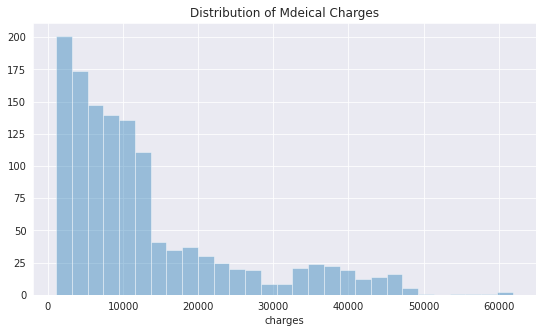

In [24]:
# Make histogram plot of charges
plt.title("Distribution of Mdeical Charges")
sns.distplot(dataframe["charges"], kde=False)

Remember to commit your notebook to Jovian after every step, so that you don't lose your work.

In [25]:
!pip install jovian --upgrade -q

/bin/bash: pip: command not found


In [26]:
import jovian

In [27]:
jovian.commit(filename=file_name)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "faaizz/02-insurance-linear-regression" on https://jovian.ai/
[jovian] Uploading notebook..
[jovian] Capturing environment..
[jovian] Error: Failed to read Anaconda environment using command: "conda env export -n base --no-builds"
[jovian] Error: Failed to read pip environment using command: "pip --disable-pip-version-check freeze"
[jovian] Committed successfully! https://jovian.ai/faaizz/02-insurance-linear-regression


'https://jovian.ai/faaizz/02-insurance-linear-regression'

## Step 2: Prepare the dataset for training

We need to convert the data from the Pandas dataframe into a PyTorch tensors for training. To do this, the first step is to convert it numpy arrays. If you've filled out `input_cols`, `categorial_cols` and `output_cols` correctly, this following function will perform the conversion to numpy arrays.

In [28]:
def dataframe_to_arrays(dataframe):
    # Make a copy of the original dataframe
    dataframe1 = dataframe.copy(deep=True)
    # Convert non-numeric categorical columns to numbers
    for col in categorical_cols:
        dataframe1[col] = dataframe1[col].astype('category').cat.codes
    # Extract input & outupts as numpy arrays
    inputs_array = dataframe1[input_cols].to_numpy()
    targets_array = dataframe1[output_cols].to_numpy()
    return inputs_array, targets_array

Read through the [Pandas documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html) to understand how we're converting categorical variables into numbers.

In [29]:
inputs_array, targets_array = dataframe_to_arrays(dataframe)
inputs_array, targets_array

(array([[4.50000000e+01, 1.00000000e+00, 2.35807000e+01, 5.00000000e+00,
         0.00000000e+00, 9.49519992e+03],
        [5.90000000e+01, 0.00000000e+00, 2.29453500e+01, 0.00000000e+00,
         1.00000000e+00, 2.49084151e+04],
        [2.10000000e+01, 0.00000000e+00, 1.63105500e+01, 1.00000000e+00,
         0.00000000e+00, 3.07243217e+03],
        ...,
        [4.20000000e+01, 1.00000000e+00, 2.74607000e+01, 3.00000000e+00,
         1.00000000e+00, 3.18038348e+04],
        [4.20000000e+01, 1.00000000e+00, 2.41142000e+01, 0.00000000e+00,
         0.00000000e+00, 5.78788078e+03],
        [2.90000000e+01, 1.00000000e+00, 3.61713000e+01, 2.00000000e+00,
         0.00000000e+00, 3.93637262e+03]]),
 array([[ 9495.199923 ],
        [24908.4150965],
        [ 3072.4321745],
        ...,
        [31803.8348323],
        [ 5787.880778 ],
        [ 3936.372617 ]]))

**Q: Convert the numpy arrays `inputs_array` and `targets_array` into PyTorch tensors. Make sure that the data type is `torch.float32`.**

In [30]:
torch.tensor(torch.from_numpy(inputs_array), dtype=torch.float32)

tensor([[4.5000e+01, 1.0000e+00, 2.3581e+01, 5.0000e+00, 0.0000e+00, 9.4952e+03],
        [5.9000e+01, 0.0000e+00, 2.2945e+01, 0.0000e+00, 1.0000e+00, 2.4908e+04],
        [2.1000e+01, 0.0000e+00, 1.6311e+01, 1.0000e+00, 0.0000e+00, 3.0724e+03],
        ...,
        [4.2000e+01, 1.0000e+00, 2.7461e+01, 3.0000e+00, 1.0000e+00, 3.1804e+04],
        [4.2000e+01, 1.0000e+00, 2.4114e+01, 0.0000e+00, 0.0000e+00, 5.7879e+03],
        [2.9000e+01, 1.0000e+00, 3.6171e+01, 2.0000e+00, 0.0000e+00, 3.9364e+03]])

In [31]:
inputs = torch.tensor(torch.from_numpy(inputs_array), dtype=torch.float32)
targets = torch.tensor(torch.from_numpy(targets_array), dtype=torch.float32)

In [32]:
inputs.dtype, targets.dtype

(torch.float32, torch.float32)

Next, we need to create PyTorch datasets & data loaders for training & validation. We'll start by creating a `TensorDataset`.

In [33]:
inputs.shape, targets.shape

(torch.Size([1271, 6]), torch.Size([1271, 1]))

In [34]:
dataset = TensorDataset(inputs, targets)

**Q: Pick a number between `0.1` and `0.2` to determine the fraction of data that will be used for creating the validation set. Then use `random_split` to create training & validation datasets.**

In [35]:
val_percent = 0.125 # between 0.1 and 0.2
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size


train_ds, val_ds = torch.utils.data.random_split(dataset, [train_size, val_size]) # Use the random_split function to split dataset into 2 parts of the desired length

Finally, we can create data loaders for training & validation.

**Q: Pick a batch size for the data loader.**

In [36]:
train_size

1113

In [37]:
batch_size = int(train_size/5)

In [38]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

Let's look at a batch of data to verify everything is working fine so far.

In [39]:
for xb, yb in train_loader:
    print("inputs:", xb)
    print("targets:", yb)
    break

inputs: tensor([[2.7000e+01, 0.0000e+00, 2.9672e+01, 1.0000e+00, 0.0000e+00, 1.6293e+04],
        [3.9000e+01, 0.0000e+00, 2.3154e+01, 5.0000e+00, 0.0000e+00, 8.3248e+03],
        [3.8000e+01, 0.0000e+00, 2.7000e+01, 2.0000e+00, 0.0000e+00, 6.9305e+03],
        ...,
        [3.8000e+01, 1.0000e+00, 2.7422e+01, 1.0000e+00, 0.0000e+00, 5.3199e+03],
        [3.3000e+01, 0.0000e+00, 4.1652e+01, 3.0000e+00, 0.0000e+00, 6.1702e+03],
        [3.5000e+01, 0.0000e+00, 3.0070e+01, 1.0000e+00, 0.0000e+00, 5.0835e+03]])
targets: tensor([[16292.5195],
        [ 8324.8330],
        [ 6930.5166],
        [ 8562.3936],
        [ 2717.2209],
        [35791.7695],
        [13408.1191],
        [20252.4199],
        [ 4852.6992],
        [ 7410.2349],
        [44487.3086],
        [ 6301.9795],
        [ 2383.4949],
        [ 8300.2002],
        [ 6652.7251],
        [ 4110.0127],
        [18469.6504],
        [15587.0127],
        [ 5193.4526],
        [13047.5879],
        [36570.8203],
        [ 4775.

Let's save our work by committing to Jovian.

In [65]:
jovian.commit(project=project_name, filename=file_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "faaizz/02-insurance-linear-regression" on https://jovian.ai/
[jovian] Uploading notebook..
[jovian] Committed successfully! https://jovian.ai/faaizz/02-insurance-linear-regression


'https://jovian.ai/faaizz/02-insurance-linear-regression'

## Step 3: Create a Linear Regression Model

Our model itself is a fairly straightforward linear regression (we'll build more complex models in the next assignment). 


In [40]:
input_size = len(input_cols)
output_size = len(output_cols)

**Q: Complete the class definition below by filling out the constructor (`__init__`), `forward`, `training_step` and `validation_step` methods.**

Hint: Think carefully about picking a good loss fuction (it's not cross entropy). Maybe try 2-3 of them and see which one works best. See https://pytorch.org/docs/stable/nn.functional.html#loss-functions

In [49]:
class InsuranceModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear =  nn.Linear(input_size, output_size)                 # fill this (hint: use input_size & output_size defined above)
        
    def forward(self, xb):
        out = self.linear(xb)                          # fill this
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        # Generate predictions
        out = self(inputs)          
        # Calcuate loss
        loss = F.l1_loss(out, targets)                          # fill this
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        loss = F.l1_loss(out, targets)                           # fill this    
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 20th epoch
        if epoch == 0 or (epoch+1) % 20 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))

Let us create a model using the `InsuranceModel` class. You may need to come back later and re-run the next cell to reinitialize the model, in case the loss becomes `nan` or `infinity`.

In [50]:
model = InsuranceModel()

Let's check out the weights and biases of the model using `model.parameters`.

In [51]:
list(model.parameters())

[Parameter containing:
 tensor([[ 0.3733, -0.1159,  0.2128,  0.1073, -0.3573, -0.1665]],
        requires_grad=True),
 Parameter containing:
 tensor([0.2051], requires_grad=True)]

One final commit before we train the model.

In [111]:
jovian.commit(project=project_name, filename=file_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "faaizz/02-insurance-linear-regression" on https://jovian.ai/
[jovian] Uploading notebook..
[jovian] Committed successfully! https://jovian.ai/faaizz/02-insurance-linear-regression


'https://jovian.ai/faaizz/02-insurance-linear-regression'

## Step 4: Train the model to fit the data

To train our model, we'll use the same `fit` function explained in the lecture. That's the benefit of defining a generic training loop - you can use it for any problem.

In [52]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

**Q: Use the `evaluate` function to calculate the loss on the validation set before training.**

In [53]:
result = evaluate(model, val_loader) # Use the the evaluate function
print(result)

{'val_loss': 14606.9033203125}



We are now ready to train the model. You may need to run the training loop many times, for different number of epochs and with different learning rates, to get a good result. Also, if your loss becomes too large (or `nan`), you may have to re-initialize the model by running the cell `model = InsuranceModel()`. Experiment with this for a while, and try to get to as low a loss as possible.

**Q: Train the model 4-5 times with different learning rates & for different number of epochs.**

Hint: Vary learning rates by orders of 10 (e.g. `1e-2`, `1e-3`, `1e-4`, `1e-5`, `1e-6`) to figure out what works.

In [54]:
model= InsuranceModel()
result = evaluate(model, val_loader) # Use the the evaluate function
print(result)

{'val_loss': 11516.439453125}


In [55]:
epochs = 1000
lr = 1e-6
history1 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [1], val_loss: 10589.6250
Epoch [20], val_loss: 103.4417
Epoch [40], val_loss: 191.3885
Epoch [60], val_loss: 59.0095
Epoch [80], val_loss: 38.7567
Epoch [100], val_loss: 25.0568
Epoch [120], val_loss: 146.7909
Epoch [140], val_loss: 63.9564
Epoch [160], val_loss: 7.6946
Epoch [180], val_loss: 94.2380
Epoch [200], val_loss: 184.6465
Epoch [220], val_loss: 121.9757
Epoch [240], val_loss: 100.8512
Epoch [260], val_loss: 281.2747
Epoch [280], val_loss: 172.9652
Epoch [300], val_loss: 72.5984
Epoch [320], val_loss: 44.7304
Epoch [340], val_loss: 12.9325
Epoch [360], val_loss: 5.2692
Epoch [380], val_loss: 19.0726
Epoch [400], val_loss: 76.9009
Epoch [420], val_loss: 202.6433
Epoch [440], val_loss: 98.2745
Epoch [460], val_loss: 32.6361
Epoch [480], val_loss: 298.3602
Epoch [500], val_loss: 10.5353
Epoch [520], val_loss: 43.5261
Epoch [540], val_loss: 50.8530
Epoch [560], val_loss: 145.7305
Epoch [580], val_loss: 11.1652
Epoch [600], val_loss: 92.7169
Epoch [620], val_loss: 99.2374
Ep

In [48]:
epochs = 1000
lr = 1e-3
history2 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 78683.5625
Epoch [40], val_loss: 187726.4219
Epoch [60], val_loss: 319867.1250
Epoch [80], val_loss: 45684.2031
Epoch [100], val_loss: 114273.8750
Epoch [120], val_loss: 63966.2930
Epoch [140], val_loss: 208699.8750
Epoch [160], val_loss: 42093.9648
Epoch [180], val_loss: 86428.1719
Epoch [200], val_loss: 10627.3350
Epoch [220], val_loss: 81051.9297
Epoch [240], val_loss: 6907.7446
Epoch [260], val_loss: 187889.5625
Epoch [280], val_loss: 117812.9844
Epoch [300], val_loss: 188029.9531
Epoch [320], val_loss: 37747.0586
Epoch [340], val_loss: 88948.0938
Epoch [360], val_loss: 8917.1201
Epoch [380], val_loss: 58628.3164
Epoch [400], val_loss: 2159.6472
Epoch [420], val_loss: 80725.8359
Epoch [440], val_loss: 7439.0317
Epoch [460], val_loss: 16025.4766
Epoch [480], val_loss: 135317.2031
Epoch [500], val_loss: 146494.7656
Epoch [520], val_loss: 305889.8438
Epoch [540], val_loss: 3552.9922
Epoch [560], val_loss: 196176.1562
Epoch [580], val_loss: 51926.6641
Epoch [600],

In [57]:
epochs = 2000
lr = 1e-7
history3 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [1], val_loss: 30.6243
Epoch [20], val_loss: 5.1208
Epoch [40], val_loss: 25.4770
Epoch [60], val_loss: 10.8590
Epoch [80], val_loss: 5.1940
Epoch [100], val_loss: 20.6603
Epoch [120], val_loss: 9.3166
Epoch [140], val_loss: 8.5274
Epoch [160], val_loss: 8.5290
Epoch [180], val_loss: 8.5173
Epoch [200], val_loss: 13.5583
Epoch [220], val_loss: 5.4347
Epoch [240], val_loss: 5.0705
Epoch [260], val_loss: 8.5055
Epoch [280], val_loss: 16.9556
Epoch [300], val_loss: 11.9677
Epoch [320], val_loss: 7.2125
Epoch [340], val_loss: 5.7602
Epoch [360], val_loss: 20.1593
Epoch [380], val_loss: 13.8208
Epoch [400], val_loss: 9.9948
Epoch [420], val_loss: 7.1817
Epoch [440], val_loss: 26.9672
Epoch [460], val_loss: 5.5187
Epoch [480], val_loss: 6.4359
Epoch [500], val_loss: 41.4754
Epoch [520], val_loss: 14.7614
Epoch [540], val_loss: 8.3040
Epoch [560], val_loss: 4.9990
Epoch [580], val_loss: 22.6717
Epoch [600], val_loss: 7.8721
Epoch [620], val_loss: 5.5954
Epoch [640], val_loss: 5.3848
Epo

In [58]:
epochs = 2000
lr = 1e-9
history4 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [1], val_loss: 6.3594
Epoch [20], val_loss: 4.4543
Epoch [40], val_loss: 4.3494
Epoch [60], val_loss: 4.3513
Epoch [80], val_loss: 4.3579
Epoch [100], val_loss: 4.3666
Epoch [120], val_loss: 4.3501
Epoch [140], val_loss: 4.3514
Epoch [160], val_loss: 4.3596
Epoch [180], val_loss: 4.3523
Epoch [200], val_loss: 4.3678
Epoch [220], val_loss: 4.3653
Epoch [240], val_loss: 4.3495
Epoch [260], val_loss: 4.3498
Epoch [280], val_loss: 4.3562
Epoch [300], val_loss: 4.3480
Epoch [320], val_loss: 4.3613
Epoch [340], val_loss: 4.3496
Epoch [360], val_loss: 4.3504
Epoch [380], val_loss: 4.3518
Epoch [400], val_loss: 4.3663
Epoch [420], val_loss: 4.3566
Epoch [440], val_loss: 4.3499
Epoch [460], val_loss: 4.3490
Epoch [480], val_loss: 4.3491
Epoch [500], val_loss: 4.3552
Epoch [520], val_loss: 4.3483
Epoch [540], val_loss: 4.3563
Epoch [560], val_loss: 4.3500
Epoch [580], val_loss: 4.3611
Epoch [600], val_loss: 4.3546
Epoch [620], val_loss: 4.3594
Epoch [640], val_loss: 4.3743
Epoch [660], val

In [59]:
epochs = 1000
lr = 1e-10
history5 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [1], val_loss: 4.3586
Epoch [20], val_loss: 4.3542
Epoch [40], val_loss: 4.3513
Epoch [60], val_loss: 4.3474
Epoch [80], val_loss: 4.3469
Epoch [100], val_loss: 4.3463
Epoch [120], val_loss: 4.3462
Epoch [140], val_loss: 4.3457
Epoch [160], val_loss: 4.3494
Epoch [180], val_loss: 4.3497
Epoch [200], val_loss: 4.3499
Epoch [220], val_loss: 4.3455
Epoch [240], val_loss: 4.3453
Epoch [260], val_loss: 4.3453
Epoch [280], val_loss: 4.3482
Epoch [300], val_loss: 4.3464
Epoch [320], val_loss: 4.3445
Epoch [340], val_loss: 4.3432
Epoch [360], val_loss: 4.3458
Epoch [380], val_loss: 4.3463
Epoch [400], val_loss: 4.3481
Epoch [420], val_loss: 4.3469
Epoch [440], val_loss: 4.3438
Epoch [460], val_loss: 4.3463
Epoch [480], val_loss: 4.3472
Epoch [500], val_loss: 4.3448
Epoch [520], val_loss: 4.3436
Epoch [540], val_loss: 4.3443
Epoch [560], val_loss: 4.3424
Epoch [580], val_loss: 4.3429
Epoch [600], val_loss: 4.3425
Epoch [620], val_loss: 4.3406
Epoch [640], val_loss: 4.3404
Epoch [660], val

**Q: What is the final validation loss of your model?**

In [64]:
history5[len(history5)-1]["val_loss"]

{'val_loss': 4.347377300262451}

In [65]:
val_loss = history5[len(history5)-1]["val_loss"]

Let's log the final validation loss to Jovian and commit the notebook

In [66]:
jovian.log_metrics(val_loss=val_loss)

[jovian] Metrics logged.


In [68]:
jovian.commit(project=project_name, filename=file_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "faaizz/02-insurance-linear-regression" on https://jovian.ai/
[jovian] Uploading notebook..
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/faaizz/02-insurance-linear-regression


'https://jovian.ai/faaizz/02-insurance-linear-regression'

Now scroll back up, re-initialize the model, and try different set of values for batch size, number of epochs, learning rate etc. Commit each experiment and use the "Compare" and "View Diff" options on Jovian to compare the different results.

## Step 5: Make predictions using the trained model

**Q: Complete the following function definition to make predictions on a single input**

In [70]:
def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = model(input)                # fill this
    prediction = predictions[0].detach()
    print("Input:", input)
    print("Target:", target)
    print("Prediction:", prediction)

In [71]:
input, target = val_ds[0]
predict_single(input, target, model)

Input: tensor([3.4000e+01, 1.0000e+00, 3.3635e+01, 0.0000e+00, 0.0000e+00, 4.3833e+03])
Target: tensor([4383.2612])
Prediction: tensor(4387.0786)


In [72]:
input, target = val_ds[10]
predict_single(input, target, model)

Input: tensor([2.3000e+01, 0.0000e+00, 3.3911e+01, 3.0000e+00, 0.0000e+00, 4.3326e+03])
Target: tensor([4332.6226])
Prediction: tensor(4332.5195)


In [73]:
input, target = val_ds[23]
predict_single(input, target, model)

Input: tensor([3.9000e+01, 0.0000e+00, 3.3290e+01, 5.0000e+00, 0.0000e+00, 8.3389e+03])
Target: tensor([8338.9229])
Prediction: tensor(8340.6270)


Are you happy with your model's predictions? Try to improve them further.

## (Optional) Step 6: Try another dataset & blog about it

While this last step is optional for the submission of your assignment, we highly recommend that you do it. Try to replicate this notebook for a different linear regression or logistic regression problem. This will help solidify your understanding, and give you a chance to differentiate the generic patterns in machine learning from problem-specific details.You can use one of these starer notebooks (just change the dataset):

- Linear regression (minimal): https://jovian.ai/aakashns/housing-linear-minimal
- Logistic regression (minimal): https://jovian.ai/aakashns/mnist-logistic-minimal

Here are some sources to find good datasets:

- https://lionbridge.ai/datasets/10-open-datasets-for-linear-regression/
- https://www.kaggle.com/rtatman/datasets-for-regression-analysis
- https://archive.ics.uci.edu/ml/datasets.php?format=&task=reg&att=&area=&numAtt=&numIns=&type=&sort=nameUp&view=table
- https://people.sc.fsu.edu/~jburkardt/datasets/regression/regression.html
- https://archive.ics.uci.edu/ml/datasets/wine+quality
- https://pytorch.org/docs/stable/torchvision/datasets.html

We also recommend that you write a blog about your approach to the problem. Here is a suggested structure for your post (feel free to experiment with it):

- Interesting title & subtitle
- Overview of what the blog covers (which dataset, linear regression or logistic regression, intro to PyTorch)
- Downloading & exploring the data
- Preparing the data for training
- Creating a model using PyTorch
- Training the model to fit the data
- Your thoughts on how to experiment with different hyperparmeters to reduce loss
- Making predictions using the model

As with the previous assignment, you can [embed Juptyer notebook cells & outputs from Jovian](https://medium.com/jovianml/share-and-embed-jupyter-notebooks-online-with-jovian-ml-df709a03064e) into your blog. 

Don't forget to share your work on the forum: https://jovian.ai/forum/t/linear-regression-and-logistic-regression-notebooks-and-blog-posts/14039

In [74]:
jovian.commit(project=project_name, filename=file_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "faaizz/02-insurance-linear-regression" on https://jovian.ai/
[jovian] Uploading notebook..
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/faaizz/02-insurance-linear-regression


'https://jovian.ai/faaizz/02-insurance-linear-regression'